In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

import sys

import models.cnn as cnn
import models.resnet as resnet
import data_visualisation as dv
import data_augmentation as da

2024-06-09 12:33:29.928919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 12:33:30.784573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-09 12:33:30.784663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-09 12:33:30.784671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load Data

In [5]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

In [3]:
# get a random sample of the data
idx = np.random.randint(0, X_train.shape[0])
X_train_sample = X_train[idx]
y_train_sample = Y_train[idx]
y_train_sample_text = Y_train_text[idx]

print('X_train_sample shape:', X_train_sample.shape)
print('y_train_sample shape:', y_train_sample)
print('y_train_sample_text shape:', y_train_sample_text)

X_train_sample shape: (100, 12)
y_train_sample shape: [0. 1. 0. 1. 0.]
y_train_sample_text shape: ['CD', 'MI']


Label distribution: [106561.  54253.  51312.  50521.  25540.]


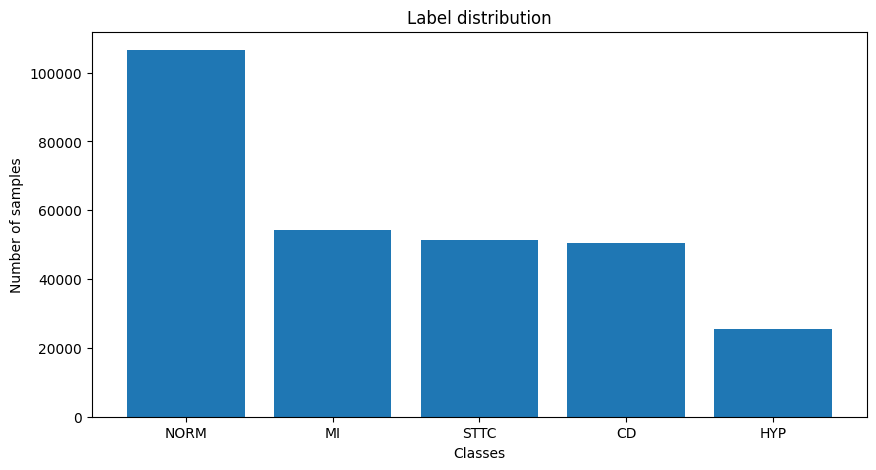

In [4]:
# get label distribution

# get label distribution
label_distribution = np.sum(Y_train, axis=0)
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
print('Label distribution:', label_distribution)
plt.figure(figsize=(10, 5))
plt.bar(classes, label_distribution)
plt.title('Label distribution')
plt.ylabel('Number of samples')
plt.xlabel('Classes')
plt.show()


In [14]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    return noised_drifted_signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# CNN Model

In [20]:
num_classes = 5
print(X_train.shape)
print(X_train.shape[1:])
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[16, 32, 64, 64, 32], kernels=[5,5,7,3,3], hidden_units=[128, 64], dropout=[0.5, 0.5])

model = keras.Model(inputs=X_input, outputs=outputs)
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

(229753, 100, 12)
(100, 12)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 96, 16)            976       
                                                                 
 bn1 (BatchNormalization)    (None, 96, 16)            64        
                                                                 
 activation_21 (Activation)  (None, 96, 16)            0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 48, 16)           0         
 g1D)                                                            
                                                                 
 conv2 (Conv1D)              (None, 44, 32)            2592      
                               

Epoch 1/10
3589/3589 [==============================] - 37s 10ms/step - loss: 0.3374 - accuracy: 0.6696 - precision: 0.7667 - recall: 0.6176 - binary_accuracy: 0.8569 - val_loss: 0.3171 - val_accuracy: 0.6955 - val_precision: 0.7702 - val_recall: 0.6653 - val_binary_accuracy: 0.8658
Epoch 2/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2897 - accuracy: 0.7140 - precision: 0.8064 - recall: 0.6897 - binary_accuracy: 0.8805 - val_loss: 0.3165 - val_accuracy: 0.6798 - val_precision: 0.7833 - val_recall: 0.6763 - val_binary_accuracy: 0.8714
Epoch 3/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2736 - accuracy: 0.7290 - precision: 0.8185 - recall: 0.7122 - binary_accuracy: 0.8884 - val_loss: 0.3119 - val_accuracy: 0.6748 - val_precision: 0.7898 - val_recall: 0.6762 - val_binary_accuracy: 0.8732
Epoch 4/10
3589/3589 [==============================] - 34s 9ms/step - loss: 0.2660 - accuracy: 0.7301 - precision: 0.8230 - recall: 0.7224 - binary_a

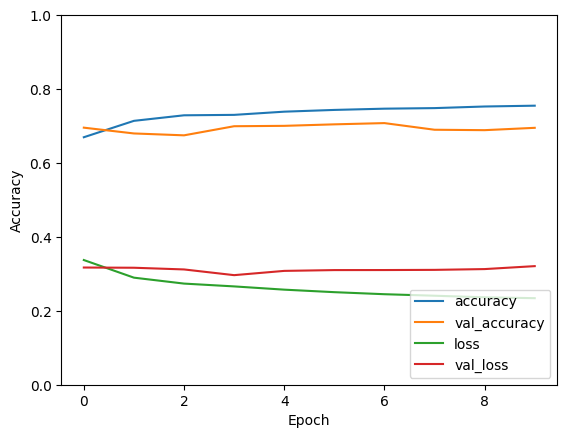

In [21]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# ResNet

In [3]:
num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])

out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

2024-06-03 17:20:47.407244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:20:47.458749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:20:47.458962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:20:47.459535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                              

Epoch 1/10


2024-06-03 16:57:16.770483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-03 16:57:17.687506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 16:57:17.691857: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7c5a6c022df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 16:57:17.691875: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-06-03 16:57:17.697551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 16:57:17.778680: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

3589/3589 [==============================] - 82s 20ms/step - loss: 0.3065 - accuracy: 0.6932 - precision: 0.7926 - recall: 0.6585 - binary_accuracy: 0.8712 - val_loss: 0.3308 - val_accuracy: 0.6917 - val_precision: 0.7776 - val_recall: 0.6768 - val_binary_accuracy: 0.8699
Epoch 2/10
3589/3589 [==============================] - 71s 20ms/step - loss: 0.2611 - accuracy: 0.7316 - precision: 0.8225 - recall: 0.7274 - binary_accuracy: 0.8923 - val_loss: 0.2861 - val_accuracy: 0.7198 - val_precision: 0.8083 - val_recall: 0.6952 - val_binary_accuracy: 0.8818
Epoch 3/10
3589/3589 [==============================] - 73s 20ms/step - loss: 0.2456 - accuracy: 0.7403 - precision: 0.8323 - recall: 0.7477 - binary_accuracy: 0.8988 - val_loss: 0.2876 - val_accuracy: 0.7029 - val_precision: 0.8052 - val_recall: 0.6933 - val_binary_accuracy: 0.8806
Epoch 4/10
3589/3589 [==============================] - 72s 20ms/step - loss: 0.2353 - accuracy: 0.7488 - precision: 0.8387 - recall: 0.7608 - binary_accuracy:

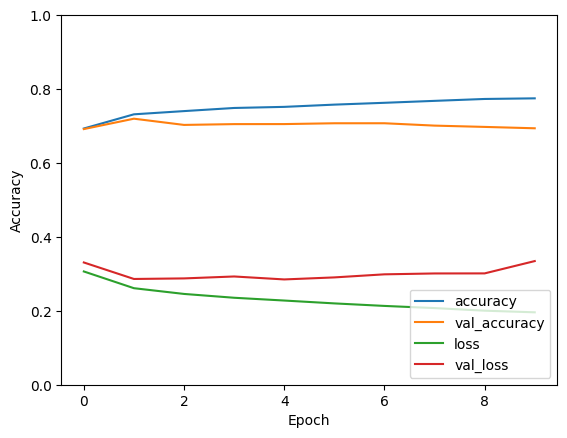

In [16]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [17]:
# save model
model.save('models/resnet_model_ptbxl_classifier.h5')

In [6]:
_, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
feature_model = keras.Model(inputs=X_input, outputs=fe)
feature_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
feature_model.summary()
feature_model.load_weights('model-weights/resnet_model_ptbxl_classifier.h5', by_name=True)
feature_model.save('model-weights/resnet_feature_model_ptbxl_classifier.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_63 (Activation)     (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

In [3]:
# load model
model = keras.models.load_model('model-weights/resnet_model_ptbxl_classifier.h5')

2024-06-09 12:33:58.575057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-09 12:33:58.719403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-09 12:33:58.723775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-09 12:33:58.724431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
# evaluate model
test_loss, test_acc, test_prec, test_rec, test_bin_acc = model.evaluate(X_test, Y_test, verbose=2)

print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)
print('Test F1:', 2 * (test_prec * test_rec) / (test_prec + test_rec))
print('Test binary accuracy:', test_bin_acc)

# auc
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
roc_auc = roc_auc_score(Y_test, y_pred)
print('ROC AUC:', roc_auc)

2024-06-09 12:34:30.606705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-09 12:34:31.781950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


923/923 - 6s - loss: 0.3314 - accuracy: 0.7066 - precision: 0.7733 - recall: 0.7347 - binary_accuracy: 0.8800 - 6s/epoch - 6ms/step
Test accuracy: 0.7065858244895935
Test precision: 0.7732792496681213
Test recall: 0.7347160577774048
Test F1: 0.7535045753419957
Test binary accuracy: 0.8800256848335266
923/923 [==============================] - 4s 4ms/step
ROC AUC: 0.9090809148767273


In [34]:
# resnet50

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
out, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)

model3 = keras.Model(inputs=X_input, outputs=out)

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_15[0][0]']               
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_167 (Activation)    (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

Epoch 1/10
3589/3589 [==============================] - 81s 20ms/step - loss: 0.3070 - accuracy: 0.6930 - precision: 0.7918 - recall: 0.6595 - binary_accuracy: 0.8708 - val_loss: 0.3130 - val_accuracy: 0.7079 - val_precision: 0.7749 - val_recall: 0.6798 - val_binary_accuracy: 0.8697
Epoch 2/10
3589/3589 [==============================] - 73s 20ms/step - loss: 0.2611 - accuracy: 0.7319 - precision: 0.8244 - recall: 0.7273 - binary_accuracy: 0.8927 - val_loss: 0.2885 - val_accuracy: 0.7010 - val_precision: 0.7904 - val_recall: 0.7020 - val_binary_accuracy: 0.8781
Epoch 3/10
3589/3589 [==============================] - 71s 20ms/step - loss: 0.2473 - accuracy: 0.7419 - precision: 0.8316 - recall: 0.7451 - binary_accuracy: 0.8982 - val_loss: 0.2924 - val_accuracy: 0.6924 - val_precision: 0.7781 - val_recall: 0.7186 - val_binary_accuracy: 0.8776
Epoch 4/10
3589/3589 [==============================] - 73s 20ms/step - loss: 0.2347 - accuracy: 0.7506 - precision: 0.8399 - recall: 0.7617 - binar

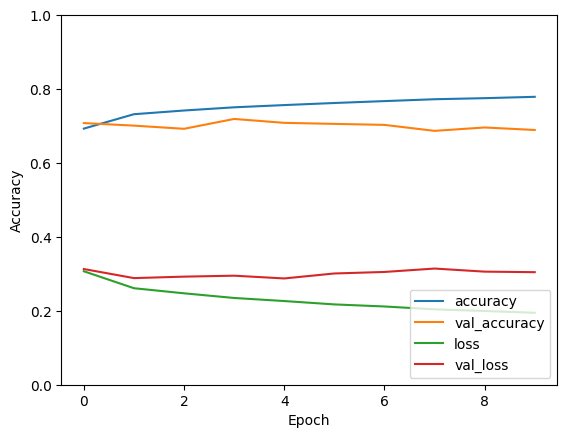

In [35]:
# train model

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model3.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()